In [1]:
%load_ext autoreload
%load_ext memory_profiler
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Seaborn enhances the aesthetics of matplotlib plots
import pandas as pd
import xarray as xr

from tempest import casestudy
from tempest import grid
from tempest import storm_tracker
from tempest import joint_distrib
from tempest import handler
from tempest.plots.hist import simple_hist
settings_path = 'settings/tropics_20d.yaml'

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [3]:
## Load handler and pass settings
hdlr = handler.Handler(settings_path)

## Initiate variables
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)

## Make grid and load data on grid 
gr = grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False)

## Get ocean mask 
lm = gr.get_landmask()
ocean = lm.Landmask == 0
ocean = ocean.values[:,:,np.newaxis]

## Load storms 
st = storm_tracker.StormTracker(gr, label_var_id = "MCS_label", overwrite = False)

##
jd = joint_distrib.JointDistribution(gr, st, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_50_Prec", nd=5, overwrite = True, dist_mask = ocean)

Data loaded from /scratchx/mcarenso/tempest/DYAMOND_SAM_post_20_days_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /scratchx/mcarenso/tempest/DYAMOND_SAM_post_20_days_Tropics/grid_attributes.pkl instead of computing
Loading storms...
loading storms from netcdf
Time elapsed for loading storms: 0.56 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 4.99 seconds


## features
+ keep days where we have all data, maybe merge 

In [4]:
## OM850_cond_prec_lag_1 as dynamic
dynamic_ds = gr.get_var_id_ds("om850_cond_prec_lag_1")
dynamic = dynamic_ds['mean_OM850_cond_Prec_lag_1']
dynamic_flat = dynamic.values.reshape(-1)  # Reshaping to 1D
days_dynamic = dynamic.days

## QV* as thermodynamic
thermo_ds = gr.get_var_id_ds("qv_sat_2d").sel(days =days_dynamic)
thermo = thermo_ds.mean_QV_sat_2d 
thermo_flat = thermo.values.reshape(-1)

## PW as water
water_ds = gr.get_var_id_ds("PW").sel(days= days_dynamic)
water = water_ds.mean_PW
water_flat = water.values.reshape(-1)

## storm coverage 
mcs_ds = gr.get_var_id_ds("Conv_MCS_label").sel(days = days_dynamic)
mcs = mcs_ds.MCS_rel_occupation
mcs_flat = mcs.values.reshape(-1)

## lat, lon because they only fall at the same places..
lat_global = mcs_ds.lat_global.values
lon_global = mcs_ds.lon_global.values

lat = np.repeat(np.repeat(lat_global[:,np.newaxis], len(lon_global), axis = 1)[:,:,np.newaxis], len(days_dynamic), axis = 2)
lon = np.repeat(np.repeat(lon_global[np.newaxis, :], len(lat_global), axis = 0)[:,:,np.newaxis], len(days_dynamic), axis = 2)

lat_flat = lat.reshape(-1)
lon_flat = lon.reshape(-1)

## labels
+ choose distrib ranks
    + first for extreme labeling
    + second for dry days to be removed


In [5]:
rank_extreme = 20
rank_dry = 10 

extreme1 = jd.dist1.percentiles[rank_extreme]
extreme2 = jd.dist2.percentiles[rank_extreme]

dry1 = jd.dist1.percentiles[rank_dry]
dry2 = jd.dist2.percentiles[rank_dry]

print(f"respectively for \n {jd.dist1.name}, {jd.dist2.name} \n ")
print(f"labels are set to 1 if values exceed \n {extreme1}, {extreme2} \n ")
print(f"Grid point is dry and put aside if value is under \n {dry1}, {dry2} \n ")

respectively for 
 dist_mean_unweighted_Prec, dist_cond_alpha_50_Prec 
 
labels are set to 1 if values exceed 
 1.0551463615894323, 21.894583854675304 
 
Grid point is dry and put aside if value is under 
 0.2353302076458932, 14.208487510681156 
 


build labels

In [6]:
prec_ds = jd.prec
mean_unweighted_Prec = prec_ds['mean_unweighted_Prec'].sel(days = days_dynamic)
cond_alpha_50_Prec = prec_ds['cond_alpha_50_Prec'].sel(days = days_dynamic)

# Convert to binary classes
binary_mean_unweighted_Prec_flattened = (mean_unweighted_Prec > extreme1).astype(int).values.reshape(-1) # Using 2 as the threshold
binary_cond_alpha_50_Prec_flattened = (cond_alpha_50_Prec > extreme2).astype(int).values.reshape(-1)

build dry filter

In [7]:
## filter out dry days
## TODO add a condition on MCS coverage or not here 
dry_filter = np.logical_and(mean_unweighted_Prec.values.reshape(-1) < dry1 , cond_alpha_50_Prec.values.reshape(-1) < dry2)

In [8]:
# Prepare the dataset
data = pd.DataFrame({
    'dynamic': dynamic_flat[~dry_filter],
    'thermo': thermo_flat[~dry_filter],
    'water': water_flat[~dry_filter],
    'mcs_cover' : mcs_flat[~dry_filter], # mcs should actually be included in filtering process
    'mean_rain' : mean_unweighted_Prec.values.reshape(-1)[~dry_filter],
    'km_scale_rain' : cond_alpha_50_Prec.values.reshape(-1)[~dry_filter],
    'lat' : lat_flat[~dry_filter],
    'lon' : lon_flat[~dry_filter],
    'mean_unweighted_Prec_label': binary_mean_unweighted_Prec_flattened[~dry_filter],
    'cond_alpha_50_Prec_label': binary_cond_alpha_50_Prec_flattened[~dry_filter]
})

In [9]:
# Split the data for 'mean_unweighted_Prec_label'
X_train, X_test, y_train, y_test = train_test_split(data[['dynamic', 'thermo', 'water', 'mcs_cover', 'lat', 'lon']], data['mean_unweighted_Prec_label'], test_size=0.2, random_state=42)

# Train a classifier for 'mean_unweighted_Prec_label'
clf = RandomForestClassifier(n_estimators=1, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the classifier
y_pred = clf.predict(X_test)
accuracy_mean_unweighted = accuracy_score(y_test, y_pred)
precision_mean_unweighted = precision_score(y_test, y_pred)
recall_mean_unweighted = recall_score(y_test, y_pred)
f1_mean_unweighted = f1_score(y_test, y_pred)

print(f"Model accuracy for 'mean_unweighted_Prec_label': {accuracy_mean_unweighted*100:.2f}%")
print(f"Precision for 'mean_unweighted_Prec_label': {precision_mean_unweighted*100:.2f}%")
print(f"Recall for 'mean_unweighted_Prec_label': {recall_mean_unweighted*100:.2f}%")
print(f"F1 Score for 'mean_unweighted_Prec_label': {f1_mean_unweighted*100:.2f}%")

importances = clf.feature_importances_
# Map these importances to the corresponding feature names
feature_names = data[['dynamic', 'thermo', 'water', 'mcs_cover', 'lat', 'lon']].columns
feature_importance_dict = dict(zip(feature_names, importances))
print(feature_importance_dict)


Model accuracy for 'mean_unweighted_Prec_label': 94.82%
Precision for 'mean_unweighted_Prec_label': 63.56%
Recall for 'mean_unweighted_Prec_label': 63.01%
F1 Score for 'mean_unweighted_Prec_label': 63.28%
{'dynamic': 0.3843654131971008, 'thermo': 0.09165785310050914, 'water': 0.12802669629601995, 'mcs_cover': 0.20917338351010534, 'lat': 0.08487874534230921, 'lon': 0.10189790855395568}


In [21]:
# Split the data for 'mean_unweighted_Prec_label'
X_train, X_test, y_train, y_test = train_test_split(data[['dynamic', 'thermo', 'water', 'mcs_cover', 'lat', 'lon','mean_rain']], data['cond_alpha_50_Prec_label'], test_size=0.2, random_state=42)

# Train a classifier for 'mean_unweighted_Prec_label'
clf = RandomForestClassifier(n_estimators=8, random_state=42) #, class_weight='balanced'
clf.fit(X_train, y_train)

# Evaluate the classifier
y_pred = clf.predict(X_test)
accuracy_mean_unweighted = accuracy_score(y_test, y_pred)
precision_mean_unweighted = precision_score(y_test, y_pred)
recall_mean_unweighted = recall_score(y_test, y_pred)
f1_mean_unweighted = f1_score(y_test, y_pred)

print(f"Model accuracy for 'cond_alpha_50_Prec_label': {accuracy_mean_unweighted*100:.2f}%")
print(f"Precision for 'cond_alpha_50_Prec_label': {precision_mean_unweighted*100:.2f}%")
print(f"Recall for 'cond_alpha_50_Prec_label': {recall_mean_unweighted*100:.2f}%")
print(f"F1 Score for 'cond_alpha_50_Prec_label': {f1_mean_unweighted*100:.2f}%")

importances = clf.feature_importances_
# Map these importances to the corresponding feature names
feature_names = data[['dynamic', 'thermo', 'water','mcs_cover', 'lat', 'lon', 'mean_rain']].columns
feature_importance_dict = dict(zip(feature_names, importances))
print(feature_importance_dict)

Model accuracy for 'cond_alpha_50_Prec_label': 91.90%
Precision for 'cond_alpha_50_Prec_label': 48.20%
Recall for 'cond_alpha_50_Prec_label': 10.11%
F1 Score for 'cond_alpha_50_Prec_label': 16.71%
{'dynamic': 0.16537176556614847, 'thermo': 0.1628046062713275, 'water': 0.13699205923622285, 'mcs_cover': 0.14272529706334933, 'lat': 0.08783353005340487, 'lon': 0.13524185516299464, 'mean_rain': 0.16903088664655241}


# Dig in RFC

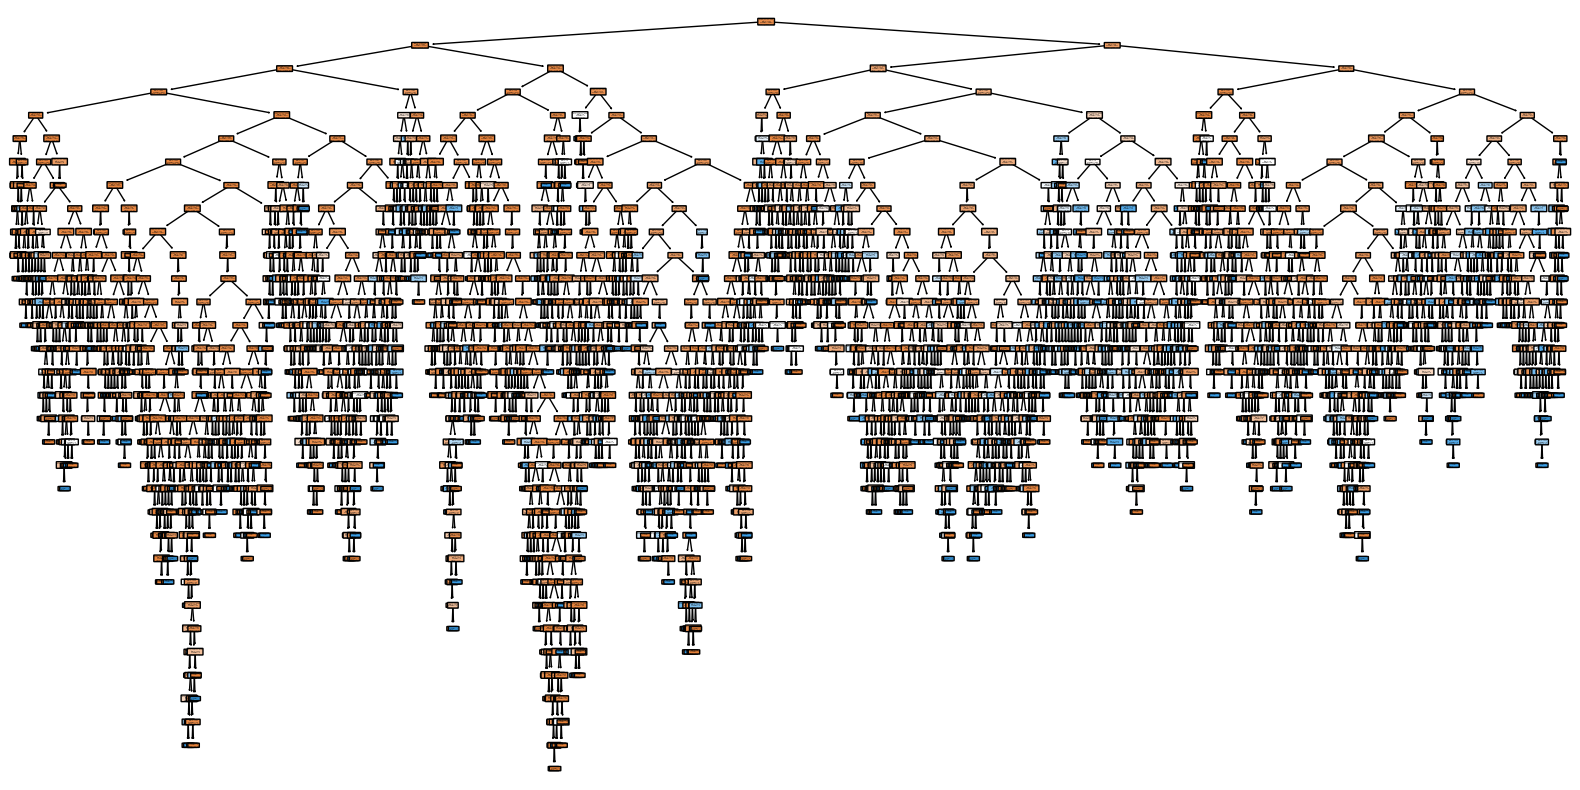

In [46]:
from sklearn.tree import plot_tree
%matplotlib inline 

# Visualize one of the trees in the forest
plt.figure(figsize=(20,10))
chosen_tree = clf.estimators_[0]  # Just as an example, choose the first tree
plot_tree(chosen_tree, filled=True, feature_names=feature_names, rounded=True)
plt.show()


In [64]:
import shap

# Create a SHAP explainer
explainer = shap.TreeExplainer(clf_mean_unweighted)
shap_values = explainer.shap_values(X_test)

# Plot the SHAP values for a single prediction
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_test.iloc[0,:])


# Tuning a single tree train/test

In [120]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Split the data for 'mean_unweighted_Prec_label'
X_train, X_test, y_train, y_test = train_test_split(data[['dynamic', 'thermo', 'water', 'mcs_cover', 'lat', 'lon', 'mean_rain']], data['cond_alpha_50_Prec_label'], test_size=0.2)

# Train a decision tree classifier for 'mean_unweighted_Prec_label'
# Adjust class_weight='balanced' to improve recall, especially if your dataset is imbalanced
dtree = DecisionTreeClassifier(criterion = 'gini', max_depth =  100 , max_leaf_nodes = None, random_state=3) #, class_weight='balanced'

dtree.fit(X_train, y_train)

# Evaluate the classifier
y_pred = dtree.predict(X_test)
accuracy_mean_unweighted = accuracy_score(y_test, y_pred)
precision_mean_unweighted = precision_score(y_test, y_pred, average='binary')  # Specify the averaging method appropriate for your case
recall_mean_unweighted = recall_score(y_test, y_pred, average='binary')  # Specify the averaging method appropriate for your case
f1_mean_unweighted = f1_score(y_test, y_pred, average='binary')  # Specify the averaging method appropriate for your case

print(f"Model accuracy for 'cond_alpha_50_Prec_label': {accuracy_mean_unweighted*100:.2f}%")
print(f"Precision for 'cond_alpha_50_Prec_label': {precision_mean_unweighted*100:.2f}%")
print(f"Recall for 'cond_alpha_50_Prec_label': {recall_mean_unweighted*100:.2f}%")
print(f"F1 Score for 'cond_alpha_50_Prec_label': {f1_mean_unweighted*100:.2f}%")

# Get feature importances
importances = dtree.feature_importances_
feature_names = data[['dynamic', 'thermo', 'water', 'mcs_cover', 'lat', 'lon','mean_rain']].columns
feature_importance_dict = dict(zip(feature_names, importances))
print(feature_importance_dict)

Model accuracy for 'cond_alpha_50_Prec_label': 87.15%
Precision for 'cond_alpha_50_Prec_label': 24.53%
Recall for 'cond_alpha_50_Prec_label': 26.46%
F1 Score for 'cond_alpha_50_Prec_label': 25.46%
{'dynamic': 0.15727859887942697, 'thermo': 0.16838879112160854, 'water': 0.13470628112325167, 'mcs_cover': 0.14438798922825322, 'lat': 0.08007965039823765, 'lon': 0.12367262051763678, 'mean_rain': 0.1914860687315852}


## Gridsearch 

In [125]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, recall_score
import numpy as np

# Split the data
X_train, X_test, y_train, y_test = train_test_split(data[['dynamic', 'thermo', 'water', 'mcs_cover', 'lat', 'lon', 'mean_rain']], data['cond_alpha_50_Prec_label'], test_size=0.2, random_state=42)

# Define the parameter grid to search
param_grid = {
    'max_depth': np.arange(1, 30),  # Adjust the range based on your dataset and prior knowledge
    'max_leaf_nodes': [None] + list(np.arange(100, 100, 1)),  # Include None and a range of values
    'class_weight': [None, 'balanced']  # Since handling class imbalance is important
}

# Initialize the classifier
dtree = DecisionTreeClassifier(criterion='gini', random_state=3)

# Define the scorer based on recall
scorer = make_scorer(recall_score, average='binary')  # Adjust the averaging method if necessary

# Set up the GridSearchCV object
grid_search = GridSearchCV(dtree, param_grid, scoring=scorer, cv=5, verbose=1, n_jobs=-1)

# Perform the grid search to find the best parameters
grid_search.fit(X_train, y_train)

# Output the best parameters and the corresponding recall
print("Best parameters found: ", grid_search.best_params_)
print("Best recall score: ", grid_search.best_score_)

# You can also retrain your model on the entire training set using the best parameters and evaluate on the test set
best_dtree = grid_search.best_estimator_
y_pred_test = best_dtree.predict(X_test)
test_recall = recall_score(y_test, y_pred_test, average='binary')  # Adjust the averaging method if necessary
print(f"Recall on the test set with best parameters: {test_recall*100:.2f}%")


Fitting 5 folds for each of 58 candidates, totalling 290 fits


Best parameters found:  {'class_weight': 'balanced', 'max_depth': 5, 'max_leaf_nodes': None}
Best recall score:  0.7375231053604436
Recall on the test set with best parameters: 73.76%


## Plots for interpretability (work in progress)

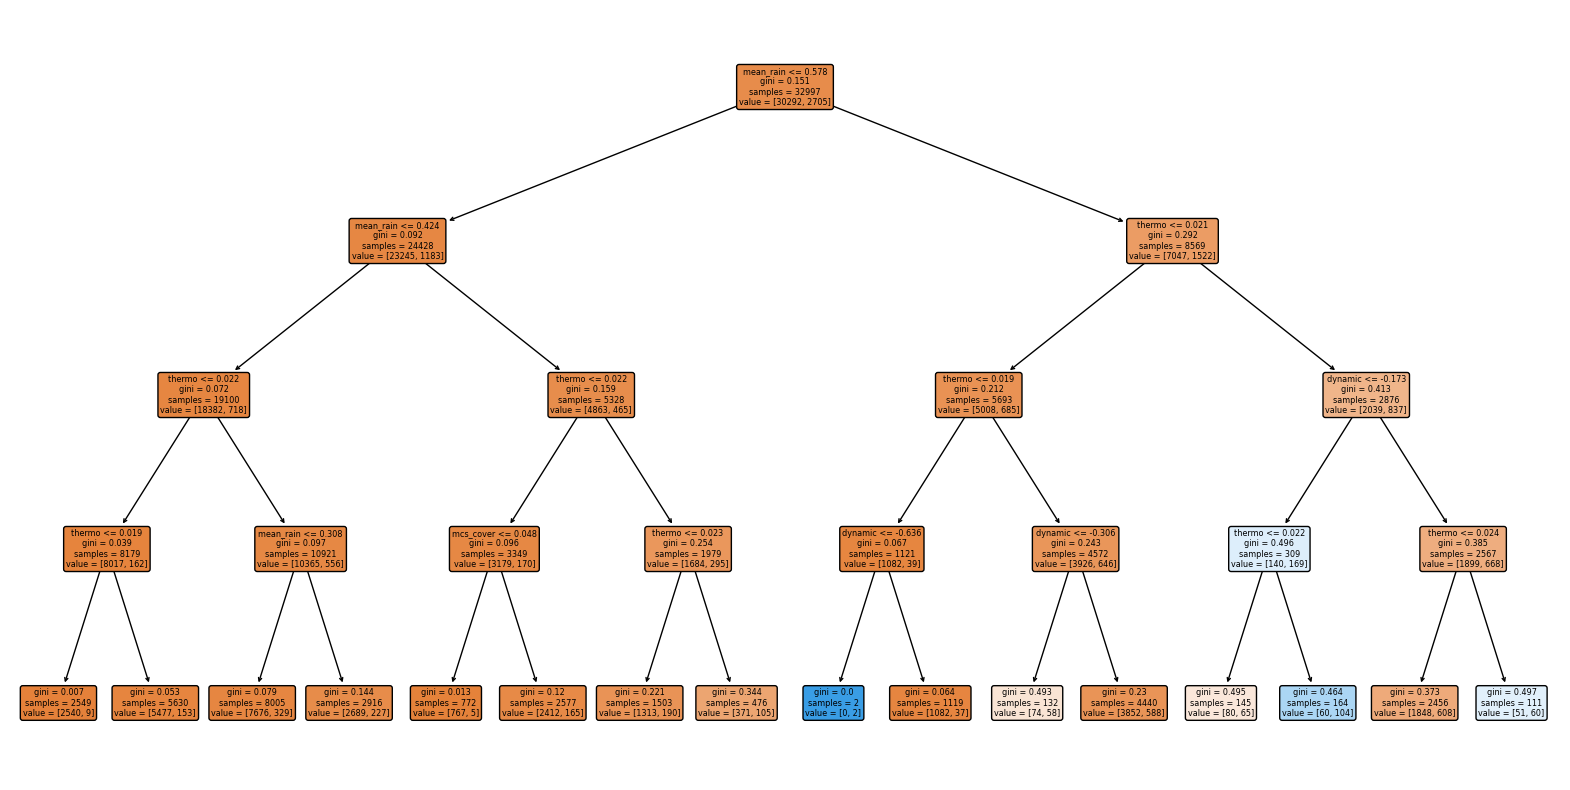

In [90]:
from sklearn.tree import plot_tree
%matplotlib inline 

# Visualize one of the trees in the forest
plt.figure(figsize=(20,10))

plot_tree(dtree, filled=True, feature_names=feature_names, rounded=True)
plt.show()

## Where are the correctly labels on the Y ?

#### Fit and predcit on whole dataset

In [205]:
# Import necessary libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Train the Decision Tree Classifier using the entire dataset
dtree_full = DecisionTreeClassifier(criterion='gini', max_depth=20, max_leaf_nodes=100) # , class_weight = 'balanced'
dtree_full.fit(data[['dynamic', 'thermo', 'water', 'mcs_cover', 'lat', 'lon']], data['cond_alpha_50_Prec_label'])  #data[, 'mean_rain']

# Predict the labels for the entire dataset
y_pred_full = dtree_full.predict(data[['dynamic', 'thermo', 'water', 'mcs_cover', 'lat', 'lon']]) # , 'mean_rain'

# Calculate the metrics
accuracy_full = accuracy_score(data['cond_alpha_50_Prec_label'], y_pred_full)
precision_full = precision_score(data['cond_alpha_50_Prec_label'], y_pred_full, average='binary')  # Specify the averaging method
recall_full = recall_score(data['cond_alpha_50_Prec_label'], y_pred_full, average='binary')  # Specify the averaging method
f1_full = f1_score(data['cond_alpha_50_Prec_label'], y_pred_full, average='binary')  # Specify the averaging method

# Print the metrics
print(f"Model accuracy for 'cond_alpha_50_Prec_label' on the whole dataset: {accuracy_full*100:.2f}%")
print(f"Precision for 'cond_alpha_50_Prec_label' on the whole dataset: {precision_full*100:.2f}%")
print(f"Recall for 'cond_alpha_50_Prec_label' on the whole dataset: {recall_full*100:.2f}%")
print(f"F1 Score for 'cond_alpha_50_Prec_label' on the whole dataset: {f1_full*100:.2f}%")

# Add the predictions to the original dataset for comparison
data['predicted_cond_alpha_50_Prec_label'] = y_pred_full

importances = dtree_full.feature_importances_
feature_names = data[['dynamic', 'thermo', 'water', 'mcs_cover', 'lat', 'lon','mean_rain']].columns
feature_importance_dict = dict(zip(feature_names, importances))
print(feature_importance_dict)

Model accuracy for 'cond_alpha_50_Prec_label' on the whole dataset: 92.59%
Precision for 'cond_alpha_50_Prec_label' on the whole dataset: 66.39%
Recall for 'cond_alpha_50_Prec_label' on the whole dataset: 18.71%
F1 Score for 'cond_alpha_50_Prec_label' on the whole dataset: 29.19%
{'dynamic': 0.35479604236397283, 'thermo': 0.2684537942380641, 'water': 0.03751571060190289, 'mcs_cover': 0.13455280683719997, 'lat': 0.045526279730372994, 'lon': 0.1591553662284874}


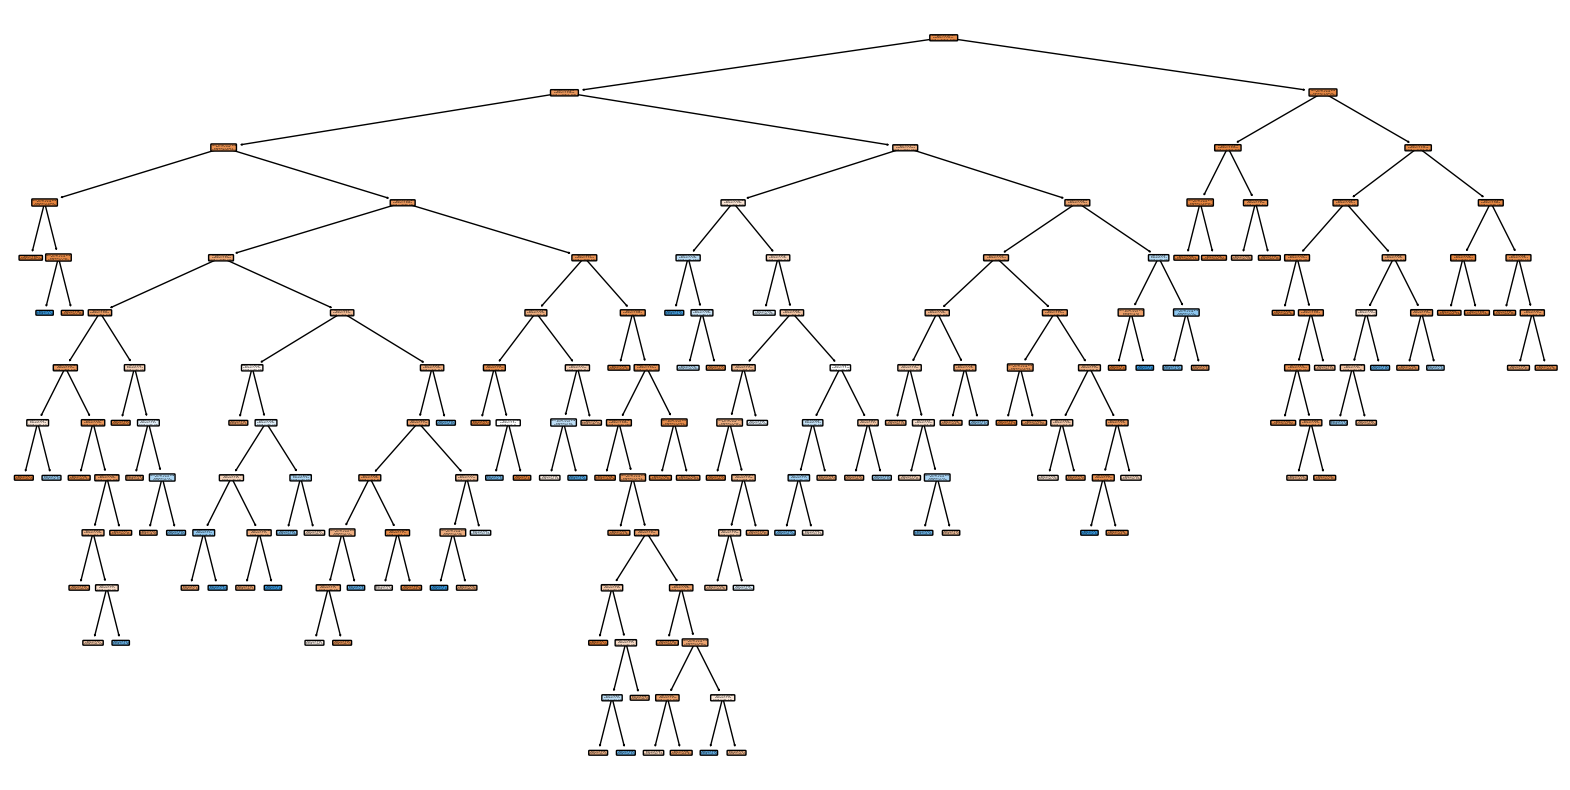

In [202]:
from sklearn.tree import plot_tree
%matplotlib inline 

# Visualize one of the trees in the forest
plt.figure(figsize=(20,10))

plot_tree(dtree_full, filled=True, feature_names=feature_names, rounded=True)
plt.show()

(<AxesSubplot:xlabel='mean_unweighted_Prec', ylabel='cond_alpha_50_Prec'>,
 <matplotlib.colorbar.Colorbar at 0x1536e6329f40>)

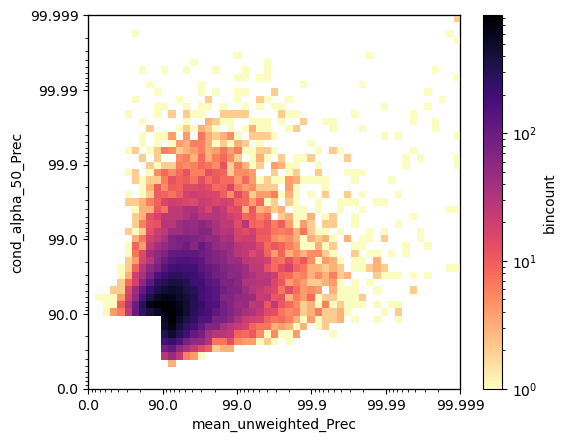

In [159]:
%matplotlib inline
bincount, density = jd.compute_joint_density(mean_unweighted_Prec.values.reshape(-1)[~dry_filter], cond_alpha_50_Prec.values.reshape(-1)[~dry_filter])
jd.plot_data(bincount, scale = 'log', label = "bincount", cmap=plt.cm.magma_r )


(<AxesSubplot:xlabel='mean_unweighted_Prec', ylabel='cond_alpha_50_Prec'>,
 <matplotlib.colorbar.Colorbar at 0x1536e7544fd0>)

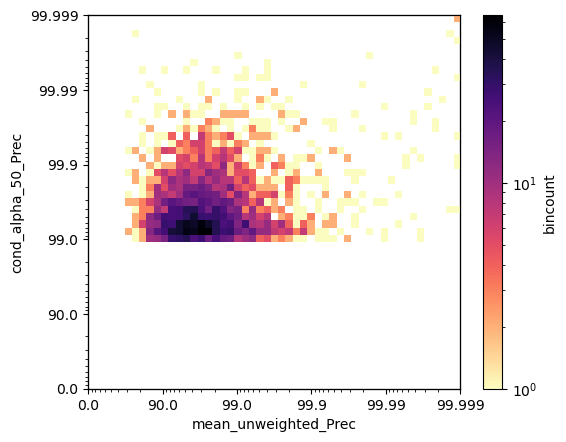

In [160]:
%matplotlib inline
sample1 = mean_unweighted_Prec.values.reshape(-1)[~dry_filter][data['cond_alpha_50_Prec_label']==1]
sample2 = cond_alpha_50_Prec.values.reshape(-1)[~dry_filter][data['cond_alpha_50_Prec_label']==1]

bincount, density = jd.compute_joint_density(sample1, sample2)
jd.plot_data(bincount, scale = 'log', label = "bincount", cmap=plt.cm.magma_r )

(<AxesSubplot:xlabel='mean_unweighted_Prec', ylabel='cond_alpha_50_Prec'>,
 <matplotlib.colorbar.Colorbar at 0x1536f50f3dc0>)

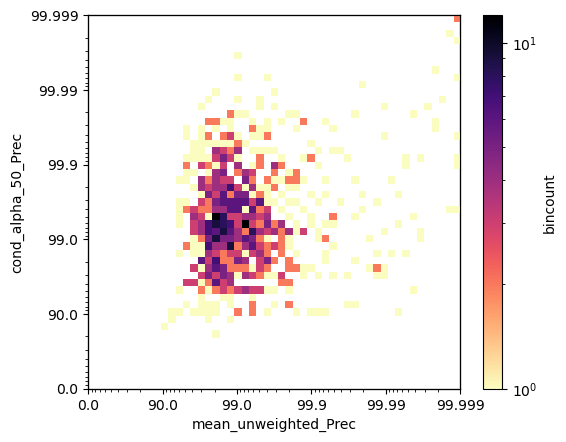

In [200]:
%matplotlib inline
sample1 = mean_unweighted_Prec.values.reshape(-1)[~dry_filter][y_pred_full==1]
sample2 = cond_alpha_50_Prec.values.reshape(-1)[~dry_filter][y_pred_full==1]

bincount, density = jd.compute_joint_density(sample1, sample2)
jd.plot_data(bincount, scale = 'log', label = "bincount", cmap=plt.cm.magma_r )
